# Text-To-Speech Examples
Google text-to-speech API reference [here](https://cloud.google.com/text-to-speech/docs/reference/rpc/google.cloud.texttospeech.v1)

In [9]:
import os
import numpy as np
import math
import random
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError
from google.cloud import texttospeech
from essential_generators import DocumentGenerator
from scipy.io import wavfile
from scipy import signal

In [75]:
BACKGROUND_DIRECTORY = "../raw_data/background_data/"
AUDIO_IGNORED_EXAMPLES_DIRECTORY = "../audio_ignored_examples/"
AUDIO_EXAMPLES_DIRECTORY = "../audio_examples/"
TEST_SET_DIRECTORY = "../data/test_set/"
TRAINING_SET_DIRECTORY = "../data/train_set/"
DEV_SET_DIRECTORY = "../data/dev_set/"
CREDENTIAL_PATH = '../credentials/basically-england.json'

In [11]:
BACKGROUND_AUDIONAMES = [name for name in os.listdir(BACKGROUND_DIRECTORY) if name.endswith("wav")]    
POSITIVE_SEGMENT = AudioSegment.from_file(AUDIO_EXAMPLES_DIRECTORY + "basically.wav")
gen = DocumentGenerator()

In [12]:
Tx = 5490 # Based on created training example
n_freq = 129 # Based on created training example
Ty = 1369 # Based on model.summary() in 1.4 with shape := (Tx, n_freq)

## Creating One Training Example

In [13]:
# Generates a 22 words sentence (~10s) with %mean_positives number of 'basically'
# TODO: prevent congregation
def generate_sentence(mean_positives, filler):
    total = 22
    num_positives = int(random.gauss(mean_positives, 1))
    num_negatives = total - num_positives
    words = []
    
    while len(words) < num_negatives:
        para = gen.paragraph()
        words += para.split()
        
    words = words[:num_negatives]
    
    random_step = 3 + int(random.gauss(2, 1)) # prevent congregation of positive and words being too short to be synthesised
    INDEXES = list(range(0, num_negatives - 3, random_step))  # -3 to prevent words being too short to be synthesised
    try:
        positive_indexes = random.sample(INDEXES, k = num_positives)
    except ValueError:
        return generate_sentence(mean_positives, filler)
    for index in positive_indexes:
        words.insert(index, filler)
    
    assert len(words) == total, "result need to be exactly 22 words (~10s)"
    sentence = " ".join(words)
    return sentence

In [14]:
# Unit Test
# sentence = generate_sentence(3, "basically")
# print(sentence)
# sentence.split("basically")

In [176]:
# List available voices in texttospeech library

# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = CREDENTIAL_PATH
# client = texttospeech.TextToSpeechClient()
# client.list_voices(language_code="en")

In [186]:
def synthesize_text(text, voice_params):
    """Returns audio segment of synthesized speech from the input string of text."""
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = CREDENTIAL_PATH
    
    client = texttospeech.TextToSpeechClient()

    input_text = texttospeech.types.SynthesisInput(text=text)
    
    # Determine the voice characteristics for the audio
    language_code = voice_params['language_codes'][0]
    name = voice_params['name']
    gender = voice_params['ssml_gender']

    # Note: the voice can also be specified by name.
    # Names of voices can be retrieved with client.list_voices().
    voice = texttospeech.types.VoiceSelectionParams(
        language_code=language_code,
        name=name,
        ssml_gender=gender)

    audio_config = texttospeech.types.AudioConfig(
        audio_encoding=texttospeech.enums.AudioEncoding.MP3)

    response = client.synthesize_speech(input_text, voice, audio_config)

    temp_filepath = "temp.wav"
    # The response's audio_content is binary.
    with open(temp_filepath, 'wb') as out:
        out.write(response.audio_content)
        segment = AudioSegment.from_file(temp_filepath)
        os.remove(temp_filepath)
    
    return segment

In [188]:
# Unit Test
output_filepath = "temp.wav"
voice_params = {
    "language_codes": ['en-US'], 
    "name": 'en-US-Standard-C', 
    "ssml_gender": texttospeech.enums.SsmlVoiceGender.FEMALE
}
sentence = "basically"
segment = synthesize_text(sentence, voice_params)
segment.export(output_filepath, format='wav')
ipd.Audio(output_filepath)

In [103]:
def create_segment(mean_positives, random_voices=False):
    """ Returns 1) concatenated audio segment and 2) inserted_points (in ms)
    """
    # make sentence with filler word
    filler = "basically"
    sentence = generate_sentence(mean_positives, filler)
    
    # Client for texttospeech
    client = texttospeech.TextToSpeechClient()
    
    # Determine the voice characteristics for the audio
    voice_params = {
        language_codes: ['en-US'], 
        name: 'en-US-Standard-C', 
        ssml_gender: texttospeech.enums.SsmlVoiceGender.FEMALE
    }
    if random_voices:
        voice_params = random.choice(client.list_voices(language_code='en').voices)
    
    # split by filler word
    negative_split = sentence.split(filler) 
    
    # concatenate audio
    # filler word is added after each negative, except for the last.
    inserted_points = []
    segment = AudioSegment.empty()
    for i in range(len(negative_split)):
        negative = negative_split[i].strip()
        try: 
            if negative != '': segment += synthesize_text(negative, voice_params)
        except CouldntDecodeError: 
            return create_segment(mean_positives, random_voices)
        if i != len(negative_split) - 1: 
            segment += POSITIVE_SEGMENT
            inserted_points.append(segment.duration_seconds * 1000)
    
    return segment, inserted_points

In [104]:
# output_filepath = AUDIO_IGNORED_EXAMPLES_DIRECTORY + "temp.wav"
# segment, inserted_points = create_segment(3)
# segment.export(output_filepath, format='wav')
# ipd.Audio(output_filepath)
# print(inserted_points)

In [105]:
def process_audio(segment):
    # Trim or pad audio segment to 10000ms
    segment = segment[:10000]
    padding = AudioSegment.silent(duration=10000)
    segment = padding.overlay(segment)
    # Set frame rate to 123000
    segment = segment.set_channels(1)
    segment = segment.set_frame_rate(123000)
    
    assert math.ceil(segment.duration_seconds) == 10, "segment needs to be exactly 10s long."
    return segment

In [106]:
# process_audio(segment)

In [107]:
def random_background(background_audionames, debug=False):
    """
    Given a list of background audio names
    Return a randomly selected background audio
    """
    # generate a random audio
    random_audio = np.random.choice(background_audionames, 1, replace=False)[0]
    if debug:
        print("Selecting background file randomly:\n    - {}".format(random_audio))
    # load audio
    global BACKGROUND_DIRECTORY
    link = BACKGROUND_DIRECTORY + random_audio
    return AudioSegment.from_wav(link)

def overlay_background(segment, debug=False):
    background = random_background(BACKGROUND_AUDIONAMES, debug)
    background = background - 30
    return background.overlay(segment, position = 0)

In [108]:
def create_X(segment, output_filepath, save):
    file_handle = segment.export(output_filepath, format="wav")

    sample_rate, samples = wavfile.read(output_filepath)
    frequencies, times, x = signal.spectrogram(samples, sample_rate)
    
    if save: print("File was saved in {}".format(output_filepath))
    else: os.remove(output_filepath)
        
    return frequencies, times, x

In [109]:
# create_X(segment, AUDIO_IGNORED_EXAMPLES_DIRECTORY + "temp.wav")

In [110]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

In [111]:
def create_Y(inserted_points):
    # Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))
    
    for point in inserted_points:
        y = insert_ones(y, point)
        
    assert y.shape == (1, Ty), "y shape needs to follow Ty!"
    
    return y

In [112]:
# inserted_points = [601.9583333333334, 3147.9166666666665, 6629.875, 10687.833333333334]
# y = create_Y(inserted_points)
# print(inserted_points) # in ms
# plt.plot(y[0])

In [113]:
def create_training_example(mean_positives, output_filepath, save=False, random_voices=False):
    segment, inserted_points = create_segment(mean_positives, random_voices)
    segment = process_audio(segment)
    frequencies, times, x = create_X(segment, output_filepath, save)
    y = create_Y(inserted_points)
    # segment = overlay_background(segment)
    
    return frequencies, times, x, y, inserted_points

File was saved in ../audio_ignored_examples/temp.wav
x: (129, 5490)
y: (1, 1369)
[601.9583333333334, 2907.9166666666665, 4613.875, 7807.833333333333]


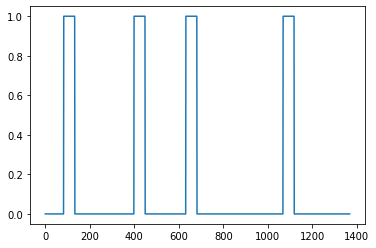

In [120]:
output_filepath = AUDIO_IGNORED_EXAMPLES_DIRECTORY + "temp.wav"
frequencies, times, x, y, inserted_points = create_training_example(4, output_filepath, save=True, random_voices=True)
print("x: {}".format(x.shape))
print("y: {}".format(y.shape))
plt.plot(y[0])
print(inserted_points)
ipd.Audio(output_filepath)

## Dataset Generation

In [115]:
# prefix refers to the prefix naming of output audio files
def create_X_Y(size, start, mean_positives, prefix, save=False, random_voices=False):
    i, X, Y = start, [], []
    for i in range(start, start + size):
        output_filepath = prefix + "_" + str(i) + ".wav"
        _, _, x, y, _ = create_training_example(mean_positives, output_filepath, save, random_voices)
        x = np.transpose(x)
        y = np.transpose(y)
        X.append(x)
        Y.append(y)
        print("Created example {}...".format(str(i)))
    return (np.array(X), np.array(Y))

In [189]:
prefix = AUDIO_IGNORED_EXAMPLES_DIRECTORY + "test"
size = 100
start = 1
mean_positives = 3
X, Y = create_X_Y(size, start, mean_positives, prefix, save=True, random_voices=True)
print("X:{} Y:{}".format(X.shape, Y.shape))
assert X.shape == (size, Tx, n_freq), "X shape is wrong"
assert Y.shape == (size, Ty, 1), "X shape is wrong"
np.save(TEST_SET_DIRECTORY + "X_Random_Voices.npy", X)
np.save(TEST_SET_DIRECTORY + "Y_Random_Voices.npy", Y)